In [1]:
# importando bibliotecas que serão usadas no projeto
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn import metrics
import sklearn.metrics as sklm
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder
from scipy.stats import norm as normdist

from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import make_pipeline, Pipeline

## Trabalho de Aprendizagem de Máquina I
#### Beatriz Farah
#### 11 de Maio de 2021

## 1. Objetivos

O presente trabalho teve como objetivo prever a qualidade de vinhos como bons ou ruins, a partir de características químicas da bebida. Para isso, foi usada a base de dados de Cortez et al., que reune informações sobre a qualidade de vinhos tintos, assim como os atributos químicos de cada vinho. Para resolver esse problema, foram comparados três classificadores, usando algumas métricas para avaliação e validação cruzada.  

## 2. Descrição do projeto

Neste trabalho, foi resolvido um problema de classificação. Para isso, foi usada a base de dados de Cortez et al., que contém dados relacionados à variante tinta do vinho português "Vinho Verde", em que a qualidade do vinho é dada a partir de 11 atributos químicos da bebida. 

Neste estudo, foi considerado o problema de prever a qualidade do vinho como "bom" ou "ruim" a partir das características químicas da bebida. Para isso, foram comparados três métodos de classificação para resolver o problema: classificador Bayes ingênuo gaussiano (NB-G), Análise discriminante linear (LDA) e Análise discriminante quadrática (QDA). 

Para avaliar o desempenho dos modelos considerados, será usada validação cruzada. Dessa forma, compararemos a performance dos classificadores, considerando métricas como Acurácia, Recall, F1 Score e AUC ROC (área abaixo da curva ROC).

## 3. Análise do problema
### 3.1 Dados trabalhados
Neste projeto, foi utilizada uma base de dados de Cortez et al., que contém informações acerca de 1599 vinhos tintos do tipo "Vinho Verde" português. Cada vinho conta com informações acerca de 11 atributos químicos, assim como uma nota que mede sua qualidade, de 0 a 10. Os dados a respeito dos vinhos estão presentes no arquivo `winequality-red.csv`:

In [2]:
# extração dos dados dos vinhos
vinho = pd.read_csv('winequality-red.csv')

Primeiro, vamos ver como os dados estão organizados:

In [3]:
# observar os primeiros dados do dataframe, para ver como estao organizados
vinho.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# ver as informações sobre o dataframe
vinho.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
# ver quais atributos estao sendo considerados
print(vinho.columns.values)

['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality']


Temos, então, que a base de dados conta com 1599 vinhos, classificados de acordo com a sua qualidade (de 0 a 10), considerando 11 atributos químicos: acidez fixada, acidez volátil, acidez cítrica, açúcares residuais, cloretos, dióxido de enxofre livre, dióxido de enxofre total, densidade, pH, sulfatos e álcool.

Como queremos classificar os vinhos como "bons" ou "ruins", precisamos analisar qual nota é razoável ser ponto de corte para essa classificação. Para isso, vamos ver qual é a distribuição de notas que medem a qualidade dos vinhos do banco de dados.

In [6]:
# mostra para cada nota, quantos vinhos existem com aquela nota no banco de dados 
vinho['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Temos, portanto, que a distribuição das notas dos vinhos no banco de dados é de 681 vinhos com nota 5, 638 com nota 6, 199 com nota 7, 53 com nota 4, 18 com nota 8 e 10 com nota 3. 

Podemos fazer um gráfico para visualizar a distribuição das notas que medem a qualidade dos vinhos do banco de dados:

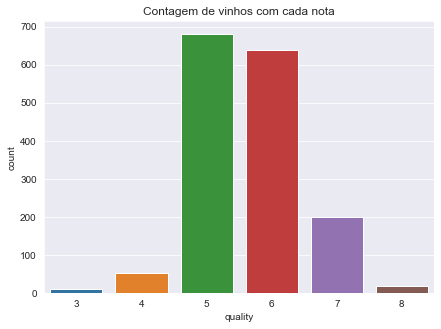

In [7]:
# histograma com as notas no eixo x e numero de vinhos com cada nota no eixo y
sns.set_style(style="darkgrid")
plt.figure(figsize=(7,5))

sns.countplot(x=vinho['quality'])
plt.title("Contagem de vinhos com cada nota")
plt.show()

Vamos considerar vinhos bons como aqueles com nota acima da média e ruins, com nota abaixo da média. Calculamos a média abaixo:

In [8]:
# nota media dos vinhos
np.mean(vinho['quality'])

5.6360225140712945

Temos que a nota média é aproximadamente $5.6$. Como as notas são números inteiros, vamos aproximar e considerar a média de mercado como 6. Assim, parece razoável tomar vinhos com nota menor ou igual a 6 (a média de mercado aproximada) como ruins, e com nota acima de 6 como bons (ou seja, os vinhos bons são aqueles com nota acima da média aproximada de mercado).

Assim, analisando os dados, uma escolha razoável para as categorias da classificação parece ser considerar que um vinho com nota menor do que 7 como ruim e com nota maior ou igual a 7 como bom. Como as notas estão em $\{3,4,5,6,7,8\}$, consideramos que as bebidas com nota em $\{3,4,5,6\}$ são ditas ruins, e as com nota em $\{7,8\}$ são ditas boas.

Vamos, portanto, adicionar uma coluna no Dataframe que diz se o vinho é bom ou ruim, de acordo com esse critério.

In [9]:
# adicionando uma coluna com "bad" se a nota for menor que 7 e "good" se for maior ou igual a 7
bins = (2, 6, 8)
group_names = ['bad', 'good']
vinho['target'] = pd.cut(vinho['quality'], bins = bins, labels = group_names)

Vamos ver como ficou o Dataframe:

In [10]:
vinho.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,bad
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad


Como vamos resolver um problema de classificação, o ideal é ter $\{0,1\}$ como target. Logo, vamos mudar mais uma vez o Dataframe, considerando vinhos ruins como 0 e vinhos bons como 1.

In [11]:
# alterando a coluna do target pra ter valores 0 e 1
bins = (2, 6, 8)
group_names = [0, 1]
vinho['target'] = pd.cut(vinho['quality'], bins = bins, labels = group_names)

Vamos ver como ficou o Dataframe:

In [12]:
vinho.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


Como usaremos apenas o target (com valores 0 e 1) para fazer a classificação, podemos desconsiderar a coluna quality. Além disso, podemos criar um dataframe $X$, que corresponde aos dados observados, e um $Y$, que corresponde à variável resposta

In [13]:
# retiramos a coluna quality: nao precisaremos dela pra classificação
vinho = vinho.drop(columns='quality')

In [14]:
# criando o dataframe X e o y
X = vinho.drop(columns = 'target')
y = vinho['target']

Finalmente, podemos então ver como está distribuída a nossa base de dados, dividida em cada classe. Primeiro, podemos fazer um gráfico de pizza para visualizar a distribuição dos dados em cada classe:

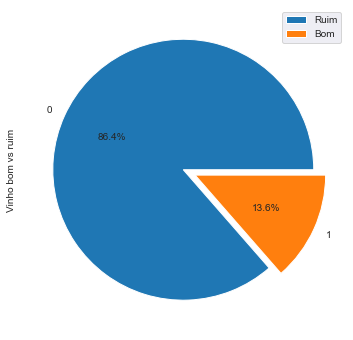

In [15]:
# grafico de pizza para ver como está dividida a base de dados
y.value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = False)
plt.ylabel('Vinho bom vs ruim')
plt.legend(['Ruim', 'Bom'])
plt.show() 

Podemos perceber que há mais dados na classe de vinhos ruins do que de vinhos bons. Vamos contar quantos vinhos ruins e quantos bons existem na base de dados:

In [16]:
# contando quantos dados temos de cada classe
y.value_counts()

0    1382
1     217
Name: target, dtype: int64

Para visualizar esses números, vamos fazer um histograma que mostra quantas observações temos de cada classe

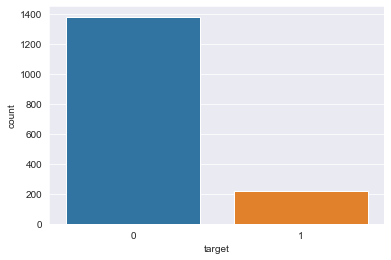

In [17]:
# histograma que mostra quantas ocorrencias existem de cada classe
sns.countplot(x=y)
plt.show()

Vamos calcular quantas vezes o número de vinhos ruins é maior do que o de vinhos bons:

In [18]:
# calculando a proporção de dados da classe 0 em relação à classe 1
1382/217

6.368663594470046

Vemos, então, que a base de dados está desbalanceada: existem, aproximadamente, 6 vezes mais vinhos ruins (da classe 0) do que bons (da classe 1) no banco em questão. Esse fato deverá ser considerado ao realizarmos a classificação, nas seções futuras deste projeto.  A base de dados desbalanceada é uma questão que deve ser tratada com atenção ao fazermos classificação, por isso serão discutidas formas de tratar essa característica da base de dados, quando fizermos classificação. Isso será discutido mais a fundo quando estivermos fazendo a classificação e aferindo as métricas de avaliação, mais adiante.

### 3.2 Análise exploratória dos dados

Neste trabalho, será solucionado o problema de classificação dos vinhos como bom ou ruim, usando três classificadores que foram tratados em aula: classificador de Bayes ingênuo gaussiano, Análise discriminante linear e Análise discriminante quadrática. Foi escolhido o classificador de Bayes ingênuo gaussiano (e não Bernoulli, por exemplo) porque o vetor aleatório de observações $\mathbf{X}$ é contínuo. 

Assim, antes de realizar as classificações e medir o desempenho de cada classificador, é importante verificar a validade das hipóteses de cada classificador. Vamos, então, relembrar as hipóteses de cada um dos classificadores considerados, para podermos finalmente ver quais são melhor atendidas nos dados em questão. 

#### 3.2.1 Hipóteses dos classificadores 

Temos, para todos os três classificadores:
- Dados observados: $X$ matriz $1599 \times 11$
- Cada linha: uma realização do vetor aleatório **contínuo** $\mathbf{X} \in \mathbb{R}^{11}$

- Variável resposta $Y \in \{0, 1\}$ - 1599 observações
- $0 \iff$ vinho ruim
- $1 \iff$ vinho bom

Segue das aulas que os classificadores considerados assumem as seguintes hipóteses:

#### Classificador de Bayes ingênuo gaussiano
- Condicionado à classe, as componentes de $\mathbf{X}$ são independentes
- $X_j | (Y = d) \sim \text{N}(\mu_{dj}, \sigma_{dj}^2), \forall j = 1,...,11$ 

#### Análise discriminante linear
- Cada  $\mathbf{X} | (Y = d)$ segue uma distribuição normal multivariada, podendo ter médias distintas, porém com uma matriz de covariância comum para todas as classes: $\mathbf{X} | (Y = d) \sim \text{N}(\mu_d, \Sigma)$

#### Análise discriminante quadrática
- Cada  $\mathbf{X} | (Y = d)$ segue uma distribuição normal multivariada, podendo ter média e matriz de covariância distintas para cada classe: $\mathbf{X} | (Y = d) \sim \text{N}(\mu_d, \Sigma_d)$

#### 3.2.2 Verificar a validade das hipóteses dos classificadores
Vamos fazer a análise exploratória dos dados, para observar quais hipóteses de cada classificador são melhores atendidas nesse conjunto de dados. Assim, verificando a validade das hipóteses de cada classsificador, poderemos ver qual classificador parece ser mais adequado para o problema de classificação considerado.

Para começar a análise exploratória, vamos primeiro observar o gráfico `pairplot`, que nos mostra as relações, dois a dois, dos atributos no conjunto de dados. 

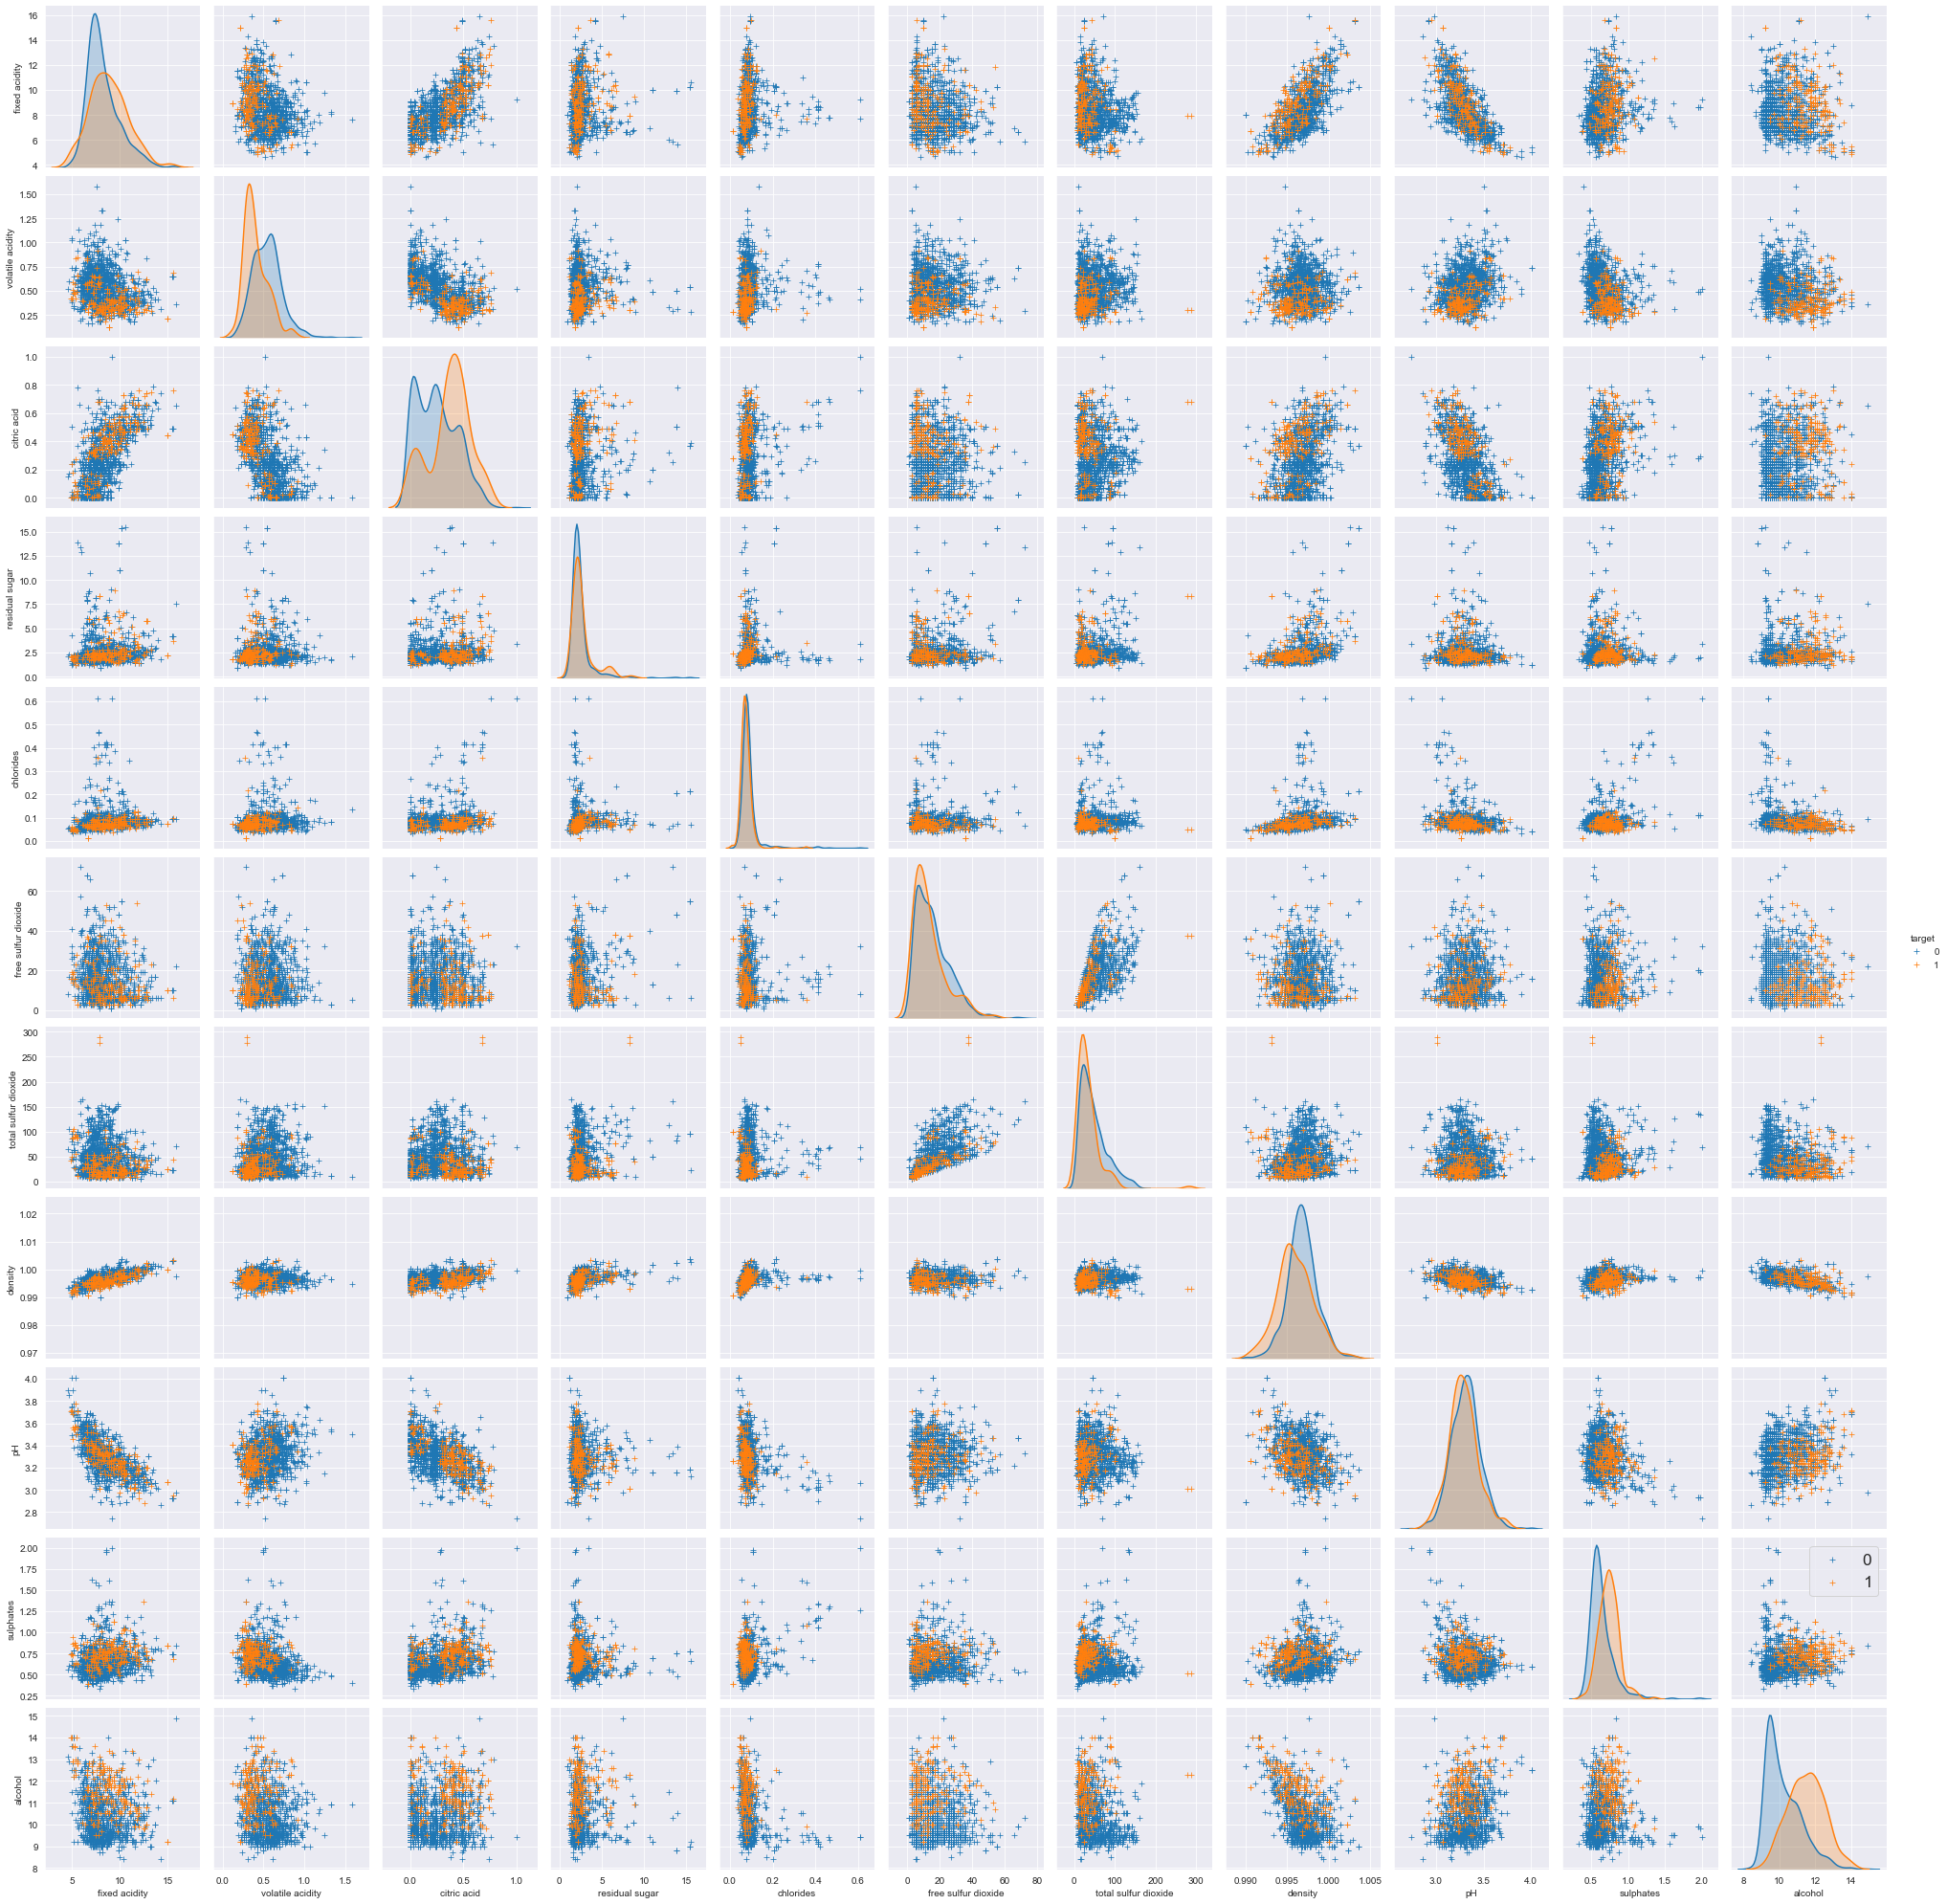

In [19]:
# fazendo o pairplot para observar as relações dos atributos, dois a dois
sns.pairplot(vinho, hue = 'target', markers = '+')
plt.legend(fontsize='xx-large')
plt.show()

Nesse gráfico, podemos ver que, nos gráficos da diagonal, que mostram a distribuição marginal dos dados em cada coluna, para a classe negativa (em azul) e positiva (em laranja), as curvas se sobrepõem muitas vezes. Essa sobreposição mostra que, provavelmente, a separação entre as duas classes não será muito clara. Além disso, podemos ver que os comportamentos das curvas da diagonal parecem aproximadamente normais. Assim, a hipótese do NB-G de que, condicionado à classe, as componentes de $\mathbf{X}$ seguem distribuição normal, talvez seja adequada. Além disso, a hipótese do LDA e QDA de que cada  $\mathbf{X} | (Y = d)$ segue uma distribuição normal multivariada também parece que pode ser razoável. Vamos ver melhor se essas hipóteses de fato são atendidas um pouco mais adiante, quando fizermos a padronização dos dados e transformação por quantis. Mas, por enquanto, a hipótese de normalidade de cada classificador parece aproximadamente atendida.

Agora, vamos observar a correlação entre os atributos para cada classe, antes de padronizar e aplicar transformação por quantil nos dados.

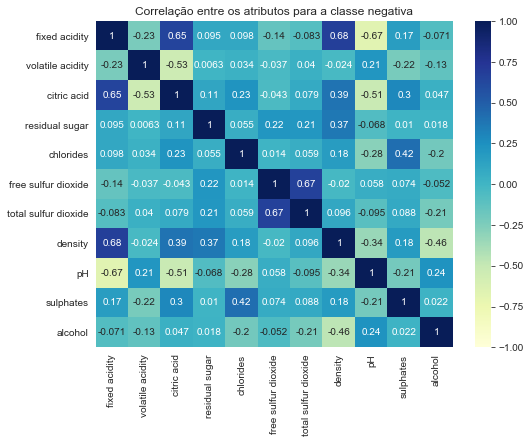

In [20]:
# grafico da matriz de correlação dos atributos na classe negativa
plt.figure(figsize = (8,6))
sns.heatmap(X[y == 0].corr(), annot = True, cmap = 'YlGnBu', vmax = 1, vmin = -1)
plt.title("Correlação entre os atributos para a classe negativa")
plt.show()

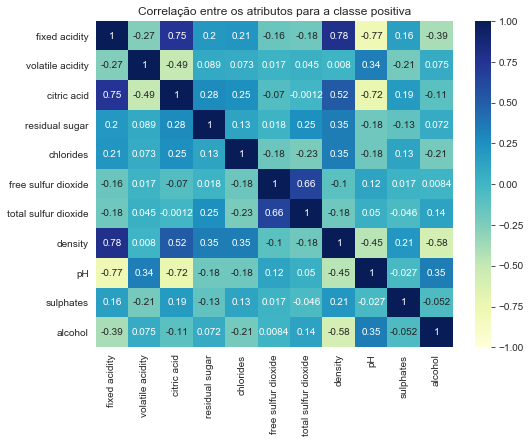

In [21]:
# grafico da matriz de correlação dos atributos na classe positiva
plt.figure(figsize = (8,6))
sns.heatmap(X[y == 1].corr(), annot = True, cmap = 'YlGnBu', vmax = 1, vmin = -1)
plt.title("Correlação entre os atributos para a classe positiva")
plt.show()

Comparando as matrizes de correlação entre os atributos para cada classe, vemos que elas não são iguais, como é pedido como hipótese para o classificador LDA. Além disso, como as matrizes de correlação não são diagonais, a hipótese do NB-G de que, condicionado à classe, as componentes de $\mathbf{X}$ são independentes não parece adequada. 

Assim, depois dessa primeira análise exploratória dos dados, sem submetê-los a nenhuma padronização ou transformação, parece que o classificador QDA é o mais adequado nesse problema de classificação, por ter as hipóteses melhor atendidas: aparentemente, pelos gráficos anteriores, parece que cada  $\mathbf{X} | (Y = d)$ segue uma distribuição normal multivariada com matriz de covariância diferente nas classes, como é pedido como hipótese no QDA. 

Por outro lado, apesar de a hipótese do NB-G de que, condicionado à classe, as componentes de $\mathbf{X}$ seguem distribuição normal parecer razoável, a hipótese de que elas são independentes não parece ser verdadeira. Analogamente, a hipótese do LDA de que  $\mathbf{X} | (Y = d)$ segue uma distribuição normal multivariada parece razoável, enquanto que a hipótese que que a matriz de covariância é igual nas classes não parece ser verdadeira.

Além disso, é importante ressaltar que, como foi visto na seção anterior deste trabalho, o conjunto de dados está desbalanceado. Como temos menos observações da classe positiva, existem menos informações para estimar a matriz de covariância, o que pode levar à inacurácia da estimação dessa matriz. Logo, as conclusões tiradas observando a matriz de correlação acima para cada classe podem, possivelmente, não serem muito confiáveis.

Assim, vamos fazer a análise exploratória aplicando padronização e transformação por quantis nos dados, para ver se essas conclusões de fato estão coerentes.

#### 3.2.3 Análise exploratória e pré-processamento

Vamos verificar a validade das hipóteses de cada classificador considerado. Para isso, vamos analisar a densidade dos atributos para cada classe. Primeiro, vamos fazer o gráfico da estimação sem realizar nenhuma padronização nem transformação nos dados.

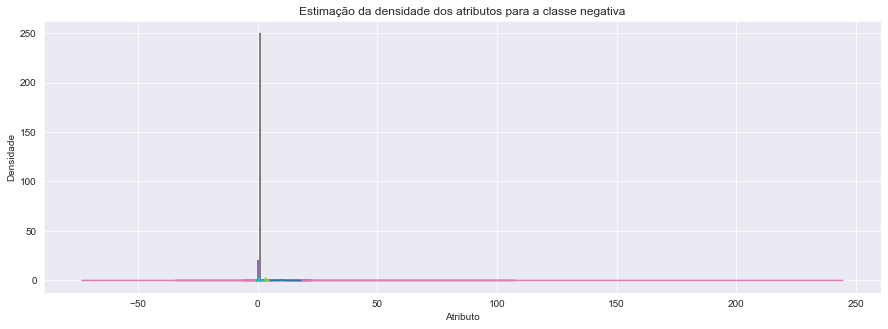

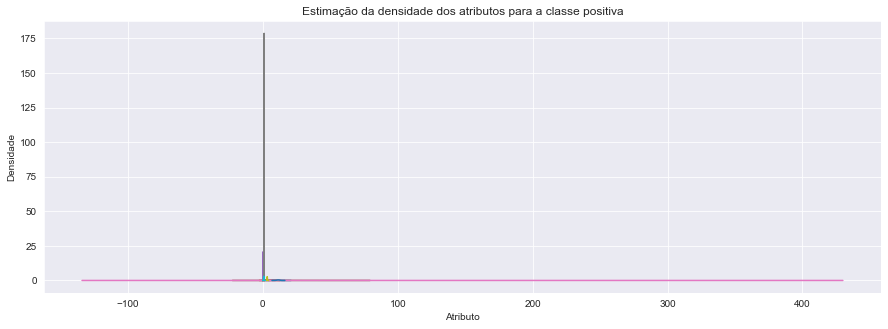

In [22]:
# fazendo o grafico da estimação da densidade dos atributos para cada classe
X[y==0].plot(kind = 'kde', ind = 25, legend = False, figsize = (15, 5))
plt.title('Estimação da densidade dos atributos para a classe negativa')
plt.xlabel('Atributo')
plt.ylabel('Densidade')
plt.show()

X[y==1].plot(kind = 'kde', ind = 25, legend = False, figsize = (15, 5))
plt.title('Estimação da densidade dos atributos para a classe positiva')
plt.xlabel('Atributo')
plt.ylabel('Densidade')
plt.show()

Essa visualização não é muito clara e não nos permite tirar nenhuma conclusão a respeito do comportamento dos atributos em cada classe. Por isso, vamos aplicar `StandardScaler`, que padroniza os atributos, removendo a média e ajustando para variância unitária, como foi feito na Aula 2 (notebook do Banco). Feita a padronização, vamos ver se a visualização da estimação da densidade dos atributos para cada classe melhora e fica mais nítida.

In [23]:
# padronizando os atributos usando StandardScaler
normalizado = pd.DataFrame(StandardScaler().fit_transform(X))

Vamos mudar os nomes das colunas do novo dataframe (que corresponde àquele com os atributos padronizados), para que eles sejam os mesmos que os nomes das colunas do dataframe X:

In [24]:
# mudando os nomes das colunas de 'normalizado' para serem iguais às de 'X'
normalizado.columns = X.columns

Vamos, também, guardar os valores do target em uma lista, que corresponde à lista das respostas para cada observação:

In [25]:
# Queremos só o valor, não mais estruturas de DataFrame
resposta = vinho['target'].values

Finalmente, podemos visualizar a estimação da densidade dos atributos para cada classe. Dessa vez, usando os atributos padronizados.

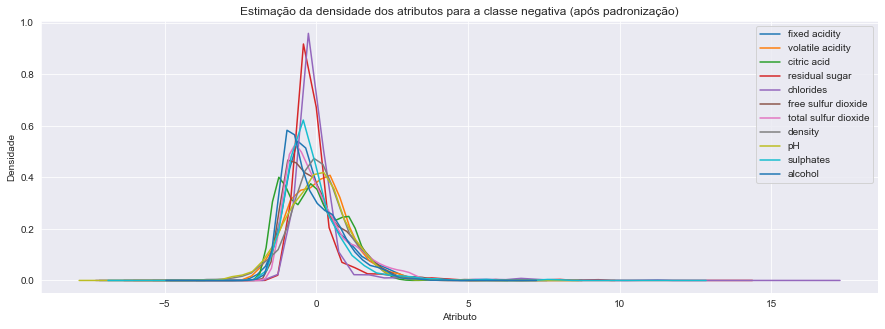

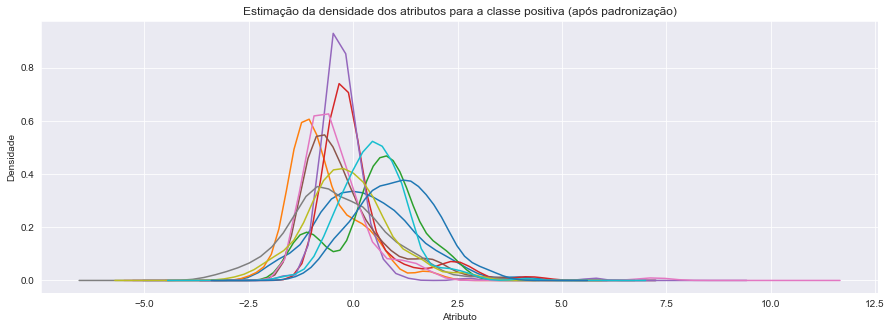

In [26]:
# fazendo o grafico da estimação da densidade dos atributos para cada classe, com os atributos padronizados
norm_plot_x = np.linspace(-7, 7, 100)
norm_plot_y = normdist.pdf(norm_plot_x, 0, 1) # pra plottar a normal padrao pra comparar o comportamento

normalizado[resposta == 0].plot(kind = 'kde', ind = 50, legend = True, figsize = (15, 5))
#plt.plot(norm_plot_x, norm_plot_y, color = 'yellow', linestyle = 'dashed', linewidth = 2)
plt.title('Estimação da densidade dos atributos para a classe negativa (após padronização)')
plt.xlabel('Atributo')
plt.ylabel('Densidade')
plt.show()

normalizado[resposta == 1].plot(kind = 'kde', ind = 50, legend = False, figsize = (15, 5))
#plt.plot(norm_plot_x, norm_plot_y, color = 'yellow', linestyle = 'dashed', linewidth = 2)
plt.title('Estimação da densidade dos atributos para a classe positiva (após padronização)')
plt.xlabel('Atributo')
plt.ylabel('Densidade')
plt.show()

A visualização melhorou bastante após a padronização dos atributos! Alguns atributos parecem aproximadamente normais, mas os gráficos ainda não parecem nítidos o suficiente para tirarmos conclusões acerca do comportamento dos atributos.

A fim de termos uma visualização ainda melhor da estimação da densidade dos atributos, vamos aplicar  `QuantileTransformer`, que transforma os atributos usando informação de quantil, para que os atributos sigam distribuição normal, como foi feito na Aula 2 (notebook do Banco).


In [27]:
# fazendo transformação por quantil, para que atributos sigam distribuição normal
norm_transf = pd.DataFrame(QuantileTransformer(output_distribution = 'normal').fit_transform(normalizado))

Novamente, vamos mudar os nomes das colunas do novo dataframe para que eles sejam os mesmos que os nomes das colunas do dataframe X:

In [28]:
# mudando os nomes das colunas de 'norm_transf' para serem iguais às de 'X'
norm_transf.columns = X.columns

Finalmente, podemos visualizar a estimação da densidade dos atributos para cada classe. Dessa vez, usando os atributos após padronização e transformação por quantis.

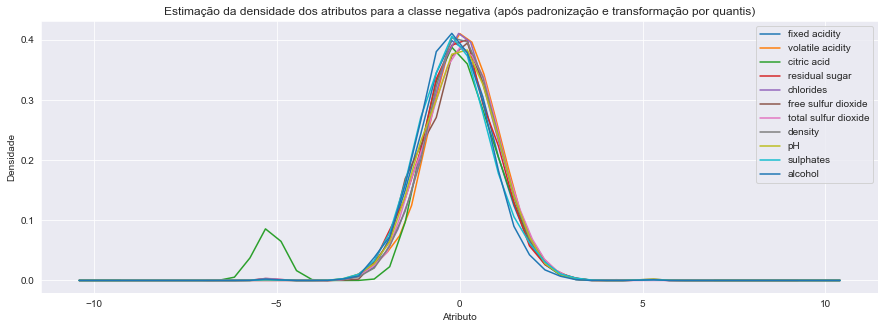

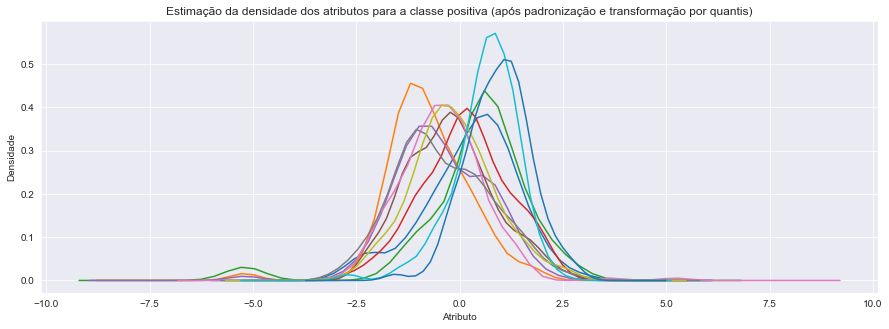

In [29]:
# fazendo o grafico da estimação da densidade dos atributos para cada classe, com os atributos após padronização e transformação por quantis
norm_transf[resposta == 0].plot(kind = 'kde', ind = 50, legend = True, figsize = (15, 5))
plt.title('Estimação da densidade dos atributos para a classe negativa (após padronização e transformação por quantis)')
plt.xlabel('Atributo')
plt.ylabel('Densidade')
plt.show()

norm_transf[resposta == 1].plot(kind = 'kde', ind = 50, legend = False, figsize = (15, 5))
plt.title('Estimação da densidade dos atributos para a classe positiva (após padronização e transformação por quantis)')
plt.xlabel('Atributo')
plt.ylabel('Densidade')
plt.show()

Agora sim, a visualização melhorou significativamente após padronização e transformação por quantis!


Temos que os atributos para a classe negativa estão bem próximos de normais. Por outro lado, para a classe positiva, os atributos estão aproximadamente normais, mas não parecem tão próximos de normais quanto no caso da classe negativa. Isso pode se dar porque o banco de dados é desbalanceado e temos menos observações da classe positiva, o que nos faz ter menos informação para estimar a densidade dos atributos para essa classe. Assim, o desbalanço pode estar causando a inacurácia na estimação da densidade dos atributos para a classe positiva, e por isso não vemos tão claramente se os atributos parecem aproximadamente normais, quanto vemos no caso da classe negativa.



Temos que, na estimação da densidade dos atributos para a classe negativa, um dos atributos (marcado no gráfico com uma curva verde) parece ter comportamento mais distante da normal. Segue da legenda que esse atributo é o ácido cítrico. Vamos fazer o gráfico da densidade do atributo ácido cítrico para a classe negativa separadamente, para vermos seu comportamento.

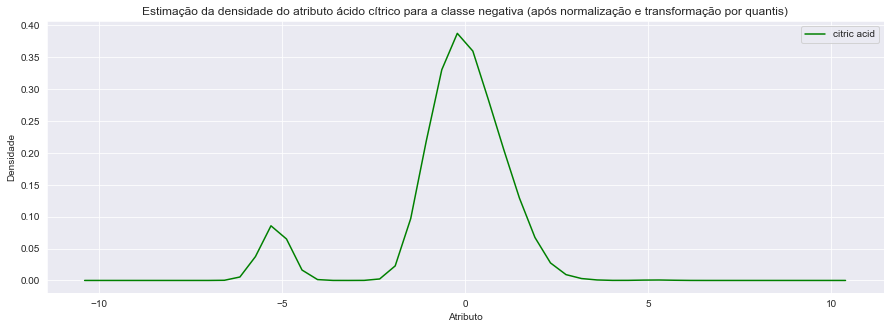

In [30]:
# gráfico da densidade do atributo ácido cítrico para a classe negativa
pd.DataFrame(norm_transf[resposta == 0]['citric acid']).plot(kind = 'kde', ind = 50, legend = False, figsize = (15, 5), label = norm_transf.columns.values, color = 'green')
plt.title('Estimação da densidade do atributo ácido cítrico para a classe negativa (após normalização e transformação por quantis)')
plt.xlabel('Atributo')
plt.ylabel('Densidade')
plt.legend()
plt.show()

Temos que a estimação da densidade do atributo ácido cítrico para a classe negativa tem comportamento um pouco mais distante da normal, devido ao seu pico em aproximadamente $-5$, que não é característico da normal. Assim, ao considerarmos que os atributos parecem aproximadamente normais, estaremos desconsiderando essa limitação na estimação. Além disso, ao falarmos que os atributos parecem normais, estaremos desconsiderando também os desvios percebidos na estimação de densidade dos atributos para a classe positiva, que são aproximadamente normais, mas são relativamente ruidosos.

Assim, temos que a hipótese do NB-G de que, condicionado à classe, as componentes de $\mathbf{X}$ são aproximadamente normais, parece adequada. Além disso, a hipótese do LDA e QDA de que $X | (Y = d)$ tem distribuição normal multivariada também parece adequada. Assim, basta analisarmos a matriz de correlação, para vermos se as demais hipóteses dos classificadores são atendidas.

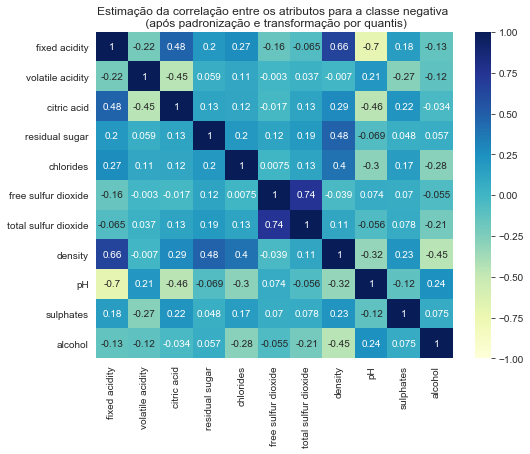

In [31]:
# grafico da matriz de correlação dos atributos na classe negativa
plt.figure(figsize = (8,6))
sns.heatmap(norm_transf[resposta == 0].corr(), annot = True, cmap = 'YlGnBu', vmax = 1, vmin = -1)
plt.title("Estimação da correlação entre os atributos para a classe negativa \n (após padronização e transformação por quantis)")
plt.show()

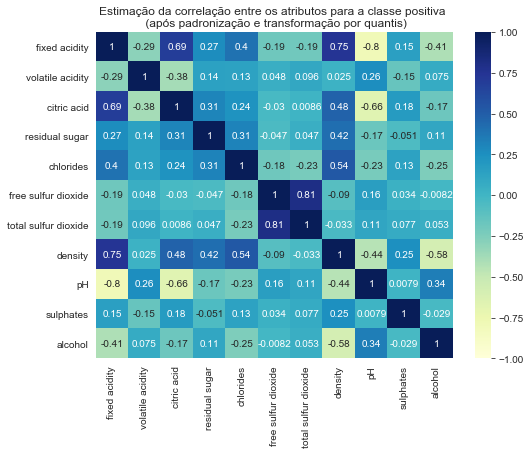

In [32]:
# grafico da matriz de correlação dos atributos na classe positiva
plt.figure(figsize = (8,6))
sns.heatmap(norm_transf[resposta == 1].corr(), annot = True, cmap = 'YlGnBu', vmax = 1, vmin = -1)
plt.title("Estimação da correlação entre os atributos para a classe positiva \n (após padronização e transformação por quantis)")
plt.show()

Temos que as matrizes de correlação não são diagonais, então a hipótese do NB-G de que, condicionado às classes, as componentes de $\mathbf{X}$ são independentes, não parece adequada. 

Além disso, comparando as matrizes de correlação entre os atributos para cada classe, vemos que elas não são iguais, como é pedido como hipótese para o classificador LDA. Assim, parece que o classificador QDA é o mais adequado nesse problema de classificação, por ter as hipóteses melhor atendidas: aparentemente, pelos gráficos anteriores, parece que cada  $\mathbf{X} | (Y = d)$ segue uma distribuição normal multivariada com matriz de covariância diferente nas classes, como é pedido como hipótese no QDA. 

Como foi dito na seção anterior, o desbalanço dos dados pode levar à inacurácia da estimação da matriz de correlação. Assim, as conclusões tiradas com base na análise da matriz de correlação podem não ser muito confiáveis. 

Decorre da análise exploratória dos dados que o classificador mais adequado para esse problema parece ser o QDA. Como o LDA e NB-G têm hipóteses que parecem não serem atendidas, não podemos concluir, entre os dois, qual seria mais adequado para o problema. Assim, temos que fazer a classificação e aferir as métricas para ver, de fato, quais classificadores são melhores nesse problema.

### 3.3 Métodos de classificação

Feita a análise exploratória e pré-processamento dos dados, podemos finalmente resolver o problema de classificação em questão. Para isso, vamos dividir as observações em conjuntos de treino e teste, como foi feito em aula. Vamos usar o parâmetro  `stratify`, que faz com que a separação entre treino e teste tenha a proporção de valores 0 e 1 igual à proporção de 0 e 1 existente em y. Isso será usado porque, como o conjunto de dados é desbalanceado, não queremos que a separação de treino e teste elimine ou reduza muito uma classe dos conjuntos de treino ou teste. Além disso, vamos usar o parâmetro  `random_state` para garantir reprodutibilidade do código. Vamos considerar a separação entre treino e teste de todo o conjunto de dados, sem nenhuma alteração.

In [33]:
# separar em treino-teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state=42)

Vamos aplicar padronização e transformação por quantis nos dados. Porém, não podemos aplicar essas mudanças usando o conjunto de dados inteiro, pois não queremos que haja vazamento de informações do conjunto de teste para o conjunto de treino. Assim, ajustamos as transformações usando `X_train`e as aplicamos em `X_test` (para não usarmos o conjunto de teste nos ajustes).

In [34]:
# transformações que serão aplicadas nos dados
# padronização
sc = StandardScaler()
# transformação por quantil
qt = QuantileTransformer(output_distribution = 'normal')

In [35]:
# ajustamos usando o conjunto de treino e aplicamos no cjto de teste
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = sc.transform(X_test)

X_train = pd.DataFrame(qt.fit_transform(X_train))
X_test = qt.transform(X_test)

Vamos usar 3 classificadores para resolver esse problema: classificador de Bayes ingênuo gaussiano (NB-G), Análise discriminante linear (LDA) e Análise discriminante quadrática (QDA). 

In [36]:
# classificadores que vamos usar no problema
NB = GaussianNB()
LDA = LinearDiscriminantAnalysis(store_covariance = True)
QDA = QuadraticDiscriminantAnalysis(store_covariance = True)

Como o banco de dados está desbalanceado, temos duas alternativas para fazer a classificação. Uma opção é manter os dados como estão, mas ajustar a forma com que fazemos a classificação. A outra opção é corrigir o desbalanço dos dados.

#### 3.3.1 Classificação mantendo a base de dados

Temos que a base de dados considerada está desbalanceada, o que pode prejudicar a classificação. Isso se dá porque o desbalanço pode fazer com que os classificadores fiquem próximos do classificador trivial, que classifica todos como 0 (classe majoritária). 

Primeiro, vamos fazer a classificação usando o banco de dados do jeito que ele está, mesmo desbalanceado. Vamos usar o ponto de corte padrão da classificação, de 0.5, ou seja, vamos rejeitar uma classe quando a probabilidade prevista para aquela classe for menor do que 0.5

In [37]:
# classificação usando o banco de dados do jeito que está, desbalanceado, com ponto de corte 0.5
NB.fit(X_train, y_train)
LDA.fit(X_train, y_train)
QDA.fit(X_train, y_train)

y_test_pred_NB = NB.predict(X_test)
y_test_pred_LDA = LDA.predict(X_test)
y_test_pred_QDA = QDA.predict(X_test)

Vamos avaliar o resultado obtido ao classificar usando o conjunto de dados desbalanceado. Vamos ver a matriz de confusão pra cada classificador:

In [38]:
# matriz de confusão
CM_NB = metrics.confusion_matrix(y_test, y_test_pred_NB)
CM_LDA = metrics.confusion_matrix(y_test, y_test_pred_LDA)
CM_QDA = metrics.confusion_matrix(y_test, y_test_pred_QDA)

In [39]:
# matriz de confusao do NB-G
CM_NB

array([[314,  32],
       [ 24,  30]], dtype=int64)

In [40]:
# matriz de confusao do LDA
CM_LDA

array([[330,  16],
       [ 34,  20]], dtype=int64)

In [41]:
# matriz de confusao do QDA
CM_QDA

array([[321,  25],
       [ 24,  30]], dtype=int64)

Vemos que, nas matrizes de confusão do NB-G e QDA, o valor da entrada $CM_{(2,1)}$ é muito próximo daquele na entrada $CM_{(2,2)}$. No caso do LDA, a entrada  $CM_{(2,1)}$ é maior do que a  $CM_{(2,2)}$. Isso significa que temos muitas ocorrências de falsos negativos para todos os classificadores (ou seja, os classsificadores erram muito falando que um vinho é ruim quando, na verdade, ele é bom). 

Como a base de dados é desbalanceada, o que deve estar acontecendo é que os classificadores se aproximam do classificador trivial, que classifica todos como label 0 (pois há mais dados do tipo 0 do que do tipo 1). No caso extremo do classificador trivial, ele erra em todos os vinhos bons, falando que são todos ruins.

Vamos aferir as métricas para os classificadores nesse caso, usando métricas que foram discutidas em aula: Acurácia, Precisão, Recall ("taxa de verdadeiros positivos"), F1 (média entre precisão e recall), AUC_ROC (área abaixo da curva ROC), usando só uma divisão de treino e teste.

In [42]:
# aferindo as metricas (só uma divisao treino/teste: só uma observação da variavel aleatoria)
models_correlation = pd.DataFrame({
    'Accuracy'    : [accuracy_score(y_test, y_test_pred_NB), accuracy_score(y_test, y_test_pred_LDA),accuracy_score(y_test, y_test_pred_QDA)],
    'Precision'   : [precision_score(y_test, y_test_pred_NB), precision_score(y_test, y_test_pred_LDA),precision_score(y_test, y_test_pred_QDA)],
    'Recall'      : [recall_score(y_test, y_test_pred_NB), recall_score(y_test, y_test_pred_LDA), recall_score(y_test, y_test_pred_QDA)],
    'F1_score'    : [f1_score(y_test, y_test_pred_NB), f1_score(y_test, y_test_pred_LDA), f1_score(y_test, y_test_pred_QDA)],
    'AUC_ROC'     : [roc_auc_score(y_test, y_test_pred_NB), roc_auc_score(y_test, y_test_pred_LDA), roc_auc_score(y_test, y_test_pred_QDA)],
    }, columns = ['Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_correlation.rename(index = {0: "Gaussian Naive Bayes", 1: "Linear Discriminant Analysis", 2:"Quadratic Discriminant Analysis"}, inplace = True)
models_correlation

,Accuracy,Precision,Recall,F1_score,AUC_ROC
Gaussian Naive Bayes,0.8600,0.483871,0.555556,0.517241,0.731535
Linear Discriminant Analysis,0.8750,0.555556,0.370370,0.444444,0.662064
Quadratic Discriminant Analysis,0.8775,0.545455,0.555556,0.550459,0.741651


Podemos ver que a acurácia para todos os classificadores é alta. Porém, como o banco de dados é desbalanceado, com $86.4 \%$ de dados na classe 0, a acurácia vista acima não é muito significativa: a acurácia obtida pelos classificadores é aproximadamente a mesma que a obtida pelo classificador que diz que todos os vinhos são ruins (0.864). 

Além disso, como foi visto na análise das matrizes de confusão, temos muitas ocorrências de falsos negativos, o que faz com que o recall seja baixo (pois recall é a taxa de verdadeiros positivos).  Temos, ainda, que Precision e F1 são baixos, e AUC_ROC também não é muito alto. Logo, essas classificações não são muito satisfatórias. 

Temos que a acurácia não é uma boa métrica para vermos se os classificadores estão com bom desempenho no nosso caso em que o banco de dados está desbalanceado. Isso se dá porque, apesar de a acurácia obtida acima ser alta para todos os classificadores, como o nosso banco de dados está desbalanceado, a acurácia de aproximadamente $0.8$ obtida em todos os classificadores não nos diz muita coisa, já que é bem próxima da acurácia do classificador trivial. Além disso, podemos perceber que, apesar de a acurácia ser alta para todos os classificadores, os valores das demais métricas são bem baixos. Assim, as métricas obtidas pelos três classificadores quando fazemos classificação usando o banco de dados sem modificação e com ponto de corte 0.5 não são satisfatórias.

Logo, para fazer a classificação com o conjunto de dados desbalanceado sem alterá-lo e termos métricas satisfatórias, será necessário ajustar a forma que fazemos a classificação. Para isso, vamos mudar a probabilidade de corte na classificação, como fizemos na Aula 3.

Primeiro, vamos guardar todas as probabilidades de predição:

In [43]:
# guardando as probabilidades de predição pra cada classe, para cada classificador
y_test_pred_proba_NB = NB.predict_proba(X_test)
y_test_pred_proba_LDA = LDA.predict_proba(X_test)
y_test_pred_proba_QDA = QDA.predict_proba(X_test)

Agora, vamos mudar a probabilidade de corte. Vamos usar como nova probabilidade de corte a probabilidade a priori da classe positiva no NB-G, como fizemos na Aula 3. Assim, vamos aceitar a classe positiva quando a probabillidade prevista para essa classe for maior do que p0 e aceitar a negativa caso contrário. Essa probabilidade é aproximadamente a proporção de dados da classe positiva no conjunto de dados. Poderíamos considerar outras probabilidades de corte também.

In [44]:
# nova probabilidade de corte
p0 = NB.class_prior_[1]
print(p0)

0.1359466221851543


Podemos, então, criar os novos vetores de predições, considerando a nova probabilidade de corte p0. Em seguida, podemos também computar as matrizes de confusão para cada classificador.

In [45]:
# mudando os y da predição, considerando o ponto de corte em p0
# depois, fazemos as novas matrizes de confusão

# NB-G
y_test_pred_p0_NB = 1*(y_test_pred_proba_NB[:,1] > p0)
CM_p0_NB = sklm.confusion_matrix(y_test, y_test_pred_p0_NB)
# LDA
y_test_pred_p0_LDA = 1*(y_test_pred_proba_LDA[:,1] > p0)
CM_p0_LDA = sklm.confusion_matrix(y_test, y_test_pred_p0_LDA)
# QDA
y_test_pred_p0_QDA = 1*(y_test_pred_proba_QDA[:,1] > p0)
CM_p0_QDA = sklm.confusion_matrix(y_test, y_test_pred_p0_QDA)

Vamos ver as novas matrizes de confusão, depois da mudança no ponto de corte da classificação.

In [46]:
# matriz de confusao do NB-G
print(CM_p0_NB)

[[273  73]
 [ 12  42]]


In [47]:
# matriz de confusao do LDA
print(CM_p0_LDA)

[[278  68]
 [  9  45]]


In [48]:
# matriz de confusao do QDA
print(CM_p0_QDA)

[[274  72]
 [ 15  39]]


Analisando a segunda linha das matrizes, podemos ver que, agora, o número de falsos negativos é bem menor do que o de verdadeiros positivos em todos os casos, para todos os três classificadores. Logo, a classificação agora acerta mais na classe positiva.

No entanto, comparando com as matrizes de confusão obtidas anteriormente, com ponto de corte 0.5, temos agora que os classificadores classificam menos verdadeiros negativos do que antes, e têm mais falso positivo (isso é visto analisando a primeira linha das matrizes). Isso se dá porque, quando mudamos a probabilidade de corte pra classe positiva para $p0 \approx 0.13 < 0.5$, assumimos que os erros de falso positivo são menos graves do que os erros falso negativo (erro tipo I é menos grave que erro tipo II). Assim, ao diminuir a probabilidade de corte para p0, aceitamos mais dados na classe 1 e assumimos que é menos grave dizer que um vinho ruim é bom (falso positivo) do que dizer que um vinho bom é ruim (falso negativo).

Vamos fazer o gráfico da curva ROC para os três classificadores, marcando de vermelho o ponto que corresponde à classificação usando p0 e de verde o ponto que corresponde à classificação com ponto de corte 0.5

In [49]:
# fazendo a curva ROC pra cada classificador
fpr_p0_NB, tpr_p0_NB, _ = sklm.roc_curve(y_test, y_test_pred_proba_NB[:,1])

fpr_p0_LDA, tpr_p0_LDA, _ = sklm.roc_curve(y_test, y_test_pred_proba_LDA[:,1])

fpr_p0_QDA, tpr_p0_QDA, _ = sklm.roc_curve(y_test, y_test_pred_proba_QDA[:,1])

fpr_p0 = [fpr_p0_NB, fpr_p0_LDA, fpr_p0_QDA]
tpr_p0 = [tpr_p0_NB, tpr_p0_LDA, tpr_p0_QDA]

In [50]:
# informações sobre os dados
Pop = np.size(y_test)
N = np.size(np.where(y_test == 0))
P = np.size(np.where(y_test == 1))

# usando ponto de corte p0
# calculos dos falsos positivos 
FP_p0 = [CM_p0_NB[0, 1], CM_p0_LDA[0, 1], CM_p0_QDA[0, 1]]
# calculo da taxa de falsos positivos
FPR_p0 = [FP_p0[i]/N for i in range(3)]
# calculo dos verdadeiros positivos
VP_p0 = [CM_p0_NB[1, 1], CM_p0_LDA[1, 1], CM_p0_QDA[1, 1]]
# calculo da taxa de verdadeiros positivos
TPR_p0 = [VP_p0[i]/P for i in range(3)]

# usando ponto de corte 0.5
# calculos dos falsos positivos 
FP = [CM_NB[0, 1], CM_LDA[0, 1], CM_QDA[0, 1]]
# calculo da taxa de falsos positivos
FPR = [FP[i]/N for i in range(3)]
# calculo dos verdadeiros positivos
VP = [CM_NB[1, 1], CM_LDA[1, 1], CM_QDA[1, 1]]
# calculo da taxa de verdadeiros positivos
TPR = [VP[i]/P for i in range(3)]

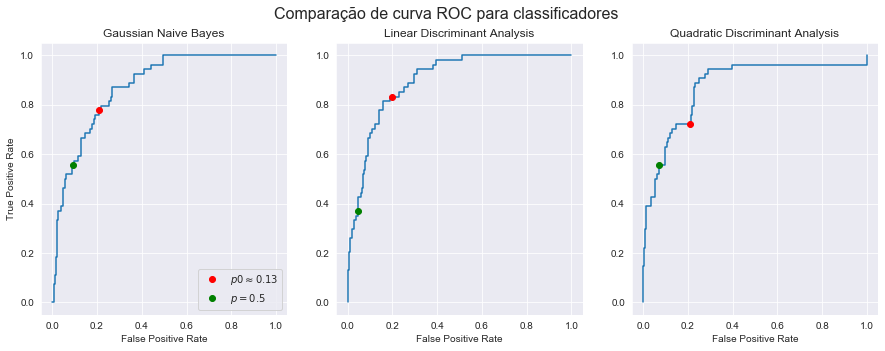

In [51]:
# fazendo o grafico
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
axs = [ax1, ax2, ax3]
methods = ['Gaussian Naive Bayes', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis']
for i, ax in enumerate(axs):
    ax.plot(fpr_p0[i], tpr_p0[i])
    ax.plot(FPR_p0[i], TPR_p0[i], 'ro', label = r'$p0 \approx 0.13$')
    ax.plot(FPR[i], TPR[i], 'go', label = '$p = 0.5$')
    ax.set_title(methods[i])
    ax.set_xlabel('False Positive Rate')

ax1.set_ylabel('True Positive Rate')
ax1.legend()
fig.suptitle("Comparação de curva ROC para classificadores", fontsize = 16)
plt.show()

Podemos ver, comparando a curva ROC dos classificadores, que o resultado obtido ao usarmos $p0 \approx 0.13$ é bem melhor do que aquele obtido ao usarmos a probabilidade de corte padrão $p = 0.5$. Isso é claro de ver no gráfico, pois, nos três gráficos, o ponto vermelho (que corresponde à classificação com $p0 \approx 0.13$) é nitidamente mais próximo do ponto ideal $(0,1)$ do que o ponto verde (que corresponde à classificação usando p = 0.5). 

Assim, a classificação mudando ponto de corte para $p0$ parece ter melhorado a classificação. Vamos aferir as métricas para ver se, de fato, a classificação melhorou.

In [52]:
# sem usar k-cv (só uma observação da variavel aleatoria)
# metricas usando p0 = 0.13
models_correlation_p0 = pd.DataFrame({
    'Accuracy'    : [accuracy_score(y_test, y_test_pred_p0_NB), accuracy_score(y_test, y_test_pred_p0_LDA),accuracy_score(y_test, y_test_pred_p0_QDA)],
    'Precision'   : [precision_score(y_test, y_test_pred_p0_NB), precision_score(y_test, y_test_pred_p0_LDA),precision_score(y_test, y_test_pred_p0_QDA)],
    'Recall'      : [recall_score(y_test, y_test_pred_p0_NB), recall_score(y_test, y_test_pred_p0_LDA), recall_score(y_test, y_test_pred_p0_QDA)],
    'F1_score'    : [f1_score(y_test, y_test_pred_p0_NB), f1_score(y_test, y_test_pred_p0_LDA), f1_score(y_test, y_test_pred_p0_QDA)],
    'AUC_ROC'     : [roc_auc_score(y_test, y_test_pred_p0_NB), roc_auc_score(y_test, y_test_pred_p0_LDA), roc_auc_score(y_test, y_test_pred_p0_QDA)],
    }, columns = ['Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])


models_correlation_p0.rename(index = {0: "Gaussian Naive Bayes", 1: "Linear Discriminant Analysis", 2:"Quadratic Discriminant Analysis"}, inplace = True)
print ("Usando probabilidade de corte p0: ")
models_correlation_p0

Usando probabilidade de corte p0: 


,Accuracy,Precision,Recall,F1_score,AUC_ROC
Gaussian Naive Bayes,0.7875,0.365217,0.777778,0.497041,0.783398
Linear Discriminant Analysis,0.8075,0.398230,0.833333,0.538922,0.818401
Quadratic Discriminant Analysis,0.7825,0.351351,0.722222,0.472727,0.757065


Vamos comparar com as métricas usando $p = 0.5$, calculadas anteriormente

In [53]:
# metricas usando p=0.5, calculadas anteriormente
print ("Usando probabilidade de corte 0.5: ")
models_correlation

Usando probabilidade de corte 0.5: 


,Accuracy,Precision,Recall,F1_score,AUC_ROC
Gaussian Naive Bayes,0.8600,0.483871,0.555556,0.517241,0.731535
Linear Discriminant Analysis,0.8750,0.555556,0.370370,0.444444,0.662064
Quadratic Discriminant Analysis,0.8775,0.545455,0.555556,0.550459,0.741651


Comparando os resultados usando como probabilidade de corte 0.5 e $p0 \approx 0.13$, vemos que o Recall (taxa de verdadeiros positivos) aumenta significativamente ao usarmos p0. Temos que, ao usar p0, a área abaixo da curva ROC aumenta para todos os classificadores, o que é um indicativo de que a classificação melhorou. Temos que a precisão continua baixa, o que faz com que F1 também seja baixo. Essas métricas também têm valor baixo quando usamos $p=0.5$, e não mudam tanto de uma classificação para a outra.

Note que a acurácia abaixa um pouco ao usarmos probabilidade de corte p0, mas isso não é muito significativo já que, como o conjunto de dados é desbalanceado, a acurácia com p = 0.5 não nos diz muita coisa sobre o desempenho real dos classificadores.

Temos assim, que, mudando a probabilidade de corte para p0, temos maior coerência ao aferir as métricas. Usando p0, segue que o classificador mais adequado parece LDA, por ter os melhores valores em todas as métricas. Seguindo LDA, o classificador adequado é Bayes ingênuo gaussiano, que supera o QDA em todas as métricas, além de ser mais simples do que o QDA. 

Assim, temos que os classificadores são ordenados do melhor ao pior, usando probabilidade de corte p0,  como: LDA > NB-G > QDA

#### 3.3.2 Classificação corrigindo o desbalanço dos dados

Nessa seção, vamos considerar outra abordagem de classificação. A base de dados considerada está desbalanceada, o que pode prejudicar a classificação, por fazer com que os algoritmos de classificação dêem como resultado o classificador trivial ou algum próximo dele. Uma forma de contornar esse problema é corrigindo o desbalanço dos dados. No nosso caso, temos muito mais vinhos ruins (dados na classe 0) do que vinhos bons (dados na classe 1). Assim, uma forma de corrigir esse desbalanço é usando técnica de oversampling na classe minoritária (1). 

Neste trabalho, foi escolhido usar a técnica `SMOTE` (_Synthetic Minority Oversampling Technique_) para corrigir o desbalanço dos dados. `SMOTE` funciona criando observações sintéticas da classe minoritária. Essa criação de dados sintéticos ocorre encontrando os k-vizinhos para as observações da classe minoritária, escolhendo aleatoriamente um dos k-vizinhos e usando-o para criar um dado sintético, que é gerado como uma combinação do k-vizinho e do dado observado da classe minoritária.

Essa técnica é efetiva porque os dados sintéticos novos da classe minoritária são plausíveis, pois estão próximos dos dados reais da classe minoritária. 

Pesquisando sobre a técnica, vi que a forma correta de usar `SMOTE` é usando essa técna de oversampling apenas nos dados de treino. Isso se justifica porque, quando usamos oversampling, estamos alterando a base de dados (acrescentando mais dados da classe minoritária do que de fato existem originalmente na base). Logo, se usássemos dados sintéticos nos conjuntos de teste, teríamos conjuntos com dados bem próximos uns dos outros, o que levaria a viés na hora de classificar. Além disso, queremos saber como os classificadores desempenham na realidade, e o conjunto de dados com oversampling não reflete a realidade.

Assim, começamos essa abordagem como a anterior, separando os conjuntos de treino e teste, para depois usar `SMOTE`.

In [54]:
# separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state=42)

Vamos usar as mesmas transformações nos dados que usamos na seção anterior. Para isso, novamente precisamos aplicar a padronização e transformação por quantis apenas no conjunto de treino, para que não haja vazamento de dados de teste pro conjunto de treino.

In [55]:
# transformações que serão aplicadas nos dados
# padronização
sc = StandardScaler()
# transformação por quantil
qt = QuantileTransformer(output_distribution = 'normal')

In [56]:
# ajustamos usando o conjunto de teste e aplicamos no cjto de treino
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = sc.transform(X_test)

X_train = pd.DataFrame(qt.fit_transform(X_train))
X_test = qt.transform(X_test)

Vamos usar `SMOTE` do `imblearn`, biblioteca para classificação com dados desbalanceados:

In [57]:
# vamos usar SMOTE
# random_state para garantir reprodutibilidade do codigo
sm = SMOTE(random_state=42)

Podemos aplicar `SMOTE` nos conjuntos de treino:

In [58]:
X_sm, y_sm = sm.fit_resample(X_train, y_train)

Vamos conferir que o conjunto de dados agora está balanceado

In [59]:
print(f'''Shape before SMOTE: {X_train.shape}
Shape after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes after SMOTE (%):')
y_sm.value_counts(normalize=True) * 100

Shape before SMOTE: (1199, 11)
Shape after SMOTE: (2072, 11)

Balance of positive and negative classes after SMOTE (%):


1    50.0
0    50.0
Name: target, dtype: float64

Agora o banco de dados está balanceado! 

Podemos, então, treinar os classificadores com o novo conjunto de dados, balanceado após `SMOTE`:

In [60]:
NB.fit(X_sm, y_sm)
LDA.fit(X_sm, y_sm)
QDA.fit(X_sm, y_sm)

y_test_pred_NB = NB.predict(X_test)
y_test_pred_LDA = LDA.predict(X_test)
y_test_pred_QDA = QDA.predict(X_test)

Para fazer a análise das métricas mais aprofundada, vamos usar validação cruzada. Como foi dito anteriormente, é necessário prestar atenção para não usar padronização, transformação por quantil e oversampling nos dados de teste. Logo, para fazer validação cruzada, temos que definir uma pipeline para fazer padronização (usando `StandardScaler`), transformação por quantil (usando `QuantileTransformer`) e oversampling (usando `SMOTE`) dos dados de treino, em cada avaliação do processo de validação cruzada. 

Temos que o `Pipeline` do `imblearn` funciona dentro da validação cruzada, aplicando as transformações apenas nos conjuntos de treino, a cada realização da validação cruzada, como nós queremos que seja: não queremos usar informações do conjunto de teste no conjunto de treino e não queremos que haja dados sintéticos nos conjuntos de teste. Várias referências foram usadas para aplicar esse método, e elas estão disponíveis na última seção do trabalho.

Assim, primeiro vamos começar construindo um Pipeline para os métodos, para podermos usar mudanças nos dados, `SMOTE` e validação cruzada.

In [61]:
# definindo os pipelines para cada classificador
# em cada pipeline, temos as transformações: padronização, tranformação por quantil e smote
pipeline_NB = Pipeline([('sc', StandardScaler()), ('qt', QuantileTransformer(output_distribution = 'normal')),('smt', SMOTE(random_state=42)),('NB',GaussianNB())])
pipeline_LDA = Pipeline([('sc', StandardScaler()), ('qt', QuantileTransformer(output_distribution = 'normal')),('smt', SMOTE(random_state=42)),('LDA',LinearDiscriminantAnalysis(store_covariance = True))])
pipeline_QDA = Pipeline([('sc', StandardScaler()), ('qt', QuantileTransformer(output_distribution = 'normal')),('smt', SMOTE(random_state=42)),('QDA',QuadraticDiscriminantAnalysis(store_covariance = True))])

Vamos definir as métricas que serão avaliadas:

In [62]:
# métricas que serão avaliadas usando k-cv
scores = ["accuracy", "precision", "recall", "f1", "roc_auc"]

Finalmente, usando `Pipeline`, podemos calcular as métricas para cada classificador. Vamos usar K-CV para separar nossos dados em 10 grupos. O método `StratifiedKFold` garante que, em cada dobra, a quantidade de dados em cada classe nos conjuntos de treino e teste obedece à proporção dos dados em cada classe no dataset inteiro. Usando `Pipeline`, podemos avaliar o desempenho de cada classificador no nosso conjunto de dados desbalanceado, usando validação cruzada.

In [63]:
# calculando o desempenho do NB-G usando K-CV
results_NB = []
for scoring in scores:
    cv = StratifiedKFold(n_splits=10)
    scores_NB = cross_val_score(pipeline_NB, X, y, scoring=scoring, cv=cv)
    results_NB.append(scores_NB.mean())

In [64]:
# calculando o desempenho do LDA usando K-CV
results_LDA = []
for scoring in scores:
    cv = StratifiedKFold(n_splits=10)
    scores_LDA = cross_val_score(pipeline_LDA, X, y, scoring=scoring, cv=cv)
    results_LDA.append(scores_LDA.mean())

In [65]:
# calculando o desempenho do QDA usando K-CV
results_QDA = []
for scoring in scores:
    cv = StratifiedKFold(n_splits=10)
    scores_QDA = cross_val_score(pipeline_QDA, X, y, scoring=scoring, cv=cv)
    results_QDA.append(scores_QDA.mean())

Podemos, finalmente, observar as métricas obtidas usando cada um dos classificadores, por meio da validação cruzada:

In [66]:
results_smote = [results_NB, results_LDA, results_QDA]
results = pd.DataFrame(results_smote, columns=scores)
results.columns = ['Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC']
results.rename(index = {0: "Gaussian Naive Bayes", 1: "Linear Discriminant Analysis", 2:"Quadratic Discriminant Analysis"}, inplace = True)
results

,Accuracy,Precision,Recall,F1_score,AUC_ROC
Gaussian Naive Bayes,0.759815,0.381609,0.759307,0.484893,0.860394
Linear Discriminant Analysis,0.774831,0.397652,0.781818,0.509742,0.882364
Quadratic Discriminant Analysis,0.755476,0.387905,0.667316,0.457157,0.814593


Temos que, usando a abordagem de alterar os dados fazendo oversampling usando `SMOTE`, a métrica de área abaixo da curva ROC (AUC_ROC) é ainda melhor do que a obtida na seção anterior, em que não modificamos o conjunto de dados. Para as demais métricas, os resultados obtidos nesta seção são próximos daqueles obtidos na seção anterior, ao usarmos ponto de corte p0. 

Temos que, corrigindo o desbalanço dos dados, o modelo com melhor desempenho é LDA, que tem valores superiores aos dos outros classificadores em todas as métricas. O classificador LDA parece ter o melhor balanço entre complexidade e desempenho. Após ele, segue NB-G, que supera QDA em todas as métricas, exceto em precisão, em que os dois classificadores estão próximos. Por fim, temos o classificador QDA, que tem o pior desempenho. 

Assim, a ordem de melhor a pior classificador nessa abordagem é: LDA > NB-G > QDA.

## 4. Discussão e resultados

Neste trabalho, foi prevista a qualidade de vinhos a partir de características químicas das bebidas. Para isso, foram usados três classificadores: Bayes ingênuo gaussiano (NB-G), Análise discriminante linear (LDA) e Análise discriminante quadrática (QDA). 

Ao fazer a análise exploratória dos dados, percebeu-se que o conjunto de dados é altamente desbalanceado, contando com cerca de 6 vezes mais vinhos ruins do que vinhos bons. Foi aplicada padronização e transformação por quantis no conjunto de dados, e foi visto que a hipótese do NB-G de que $X_j | (Y = d) \sim \text{N}(\mu_{dj}, \sigma_{dj}^2), \forall j = 1,...,11$ é verificada. Além disso, a hipótese do LDA e QDA de que cada $\mathbf{X} | (Y = d)$ segue uma distribuição normal multivariada também é verificada. 

Ainda na Análise exploratória, foi visto que a matriz de covariância não é diagonal, logo a hipótese do NB-G de que, condicionado à classe, as componentes de $\mathbf{X}$ são independentes não parece apropriada. Ademais, a matriz de correlação de cada classe não é igual, logo a hipótese do LDA de que $X|(y=d)$ tem matriz de covariância igual nas classes não é verificada. Assim, conclui-se da análise exploratória que o classificador mais apropriado é QDA.

Como o conjunto de dados é desbalanceado, a classificação foi realizada de duas formas: mantendo o conjunto de dados e alterando o ponto de corte da classificação, e mudando o conjunto de dados por meio de oversampling na classe minoritária. No primeiro caso, as métricas foram avaliadas como nas Aulas 2 e 3, olhando para uma divisão de treino e teste e estimando o risco usando teste, e comparando com as métricas obtidas pelo ponto de corte padrão 0.5. Na segunda abordagem, foi usada validação cruzada K-CV. 

Nas duas abordagens de classificação, obtivemos que a ordem de melhor a pior classificador é: LDA > NB-G >QDA. Nas duas abordagens, os valores obtidos em cada métrica são próximos. Temos que, na classificação nos dois casos, o classificador com pior desempenho foi QDA, o que contraria a conclusão que obtivemos ao fazer a análise exploratória, quando achamos que o classificador mais adequado (com as hipóteses melhor atendidas) era o QDA. Essa aparente contradição pode ter ocorrido porque a conclusão da superioridade do QDA decorre da observação da matriz de correlação para cada classe, na análise exploratória dos dados. Mas, o desbalanço dos dados causa dificuldades na estimação da matriz de correlação da classe positiva, porque temos menos informações para estimar a matriz para essa classe. Assim, o desbalanço de dados pode levar à inacurácia da estimação da matriz de correlação para a classe positiva, que nos levou a uma conclusão que não se realizou na prática.

Podemos comparar os resultados obtidos para cada métrica usando as duas abordagens de classificação.

In [67]:
print('Resultados da abordagem sem mudar conjunto de dados, usando probabilidade de corte p0:')
models_correlation_p0

Resultados da abordagem sem mudar conjunto de dados, usando probabilidade de corte p0:


,Accuracy,Precision,Recall,F1_score,AUC_ROC
Gaussian Naive Bayes,0.7875,0.365217,0.777778,0.497041,0.783398
Linear Discriminant Analysis,0.8075,0.398230,0.833333,0.538922,0.818401
Quadratic Discriminant Analysis,0.7825,0.351351,0.722222,0.472727,0.757065


In [68]:
print('Resultados da abordagem mudando o conjunto de dados, usando SMOTE:')
results

Resultados da abordagem mudando o conjunto de dados, usando SMOTE:


,Accuracy,Precision,Recall,F1_score,AUC_ROC
Gaussian Naive Bayes,0.759815,0.381609,0.759307,0.484893,0.860394
Linear Discriminant Analysis,0.774831,0.397652,0.781818,0.509742,0.882364
Quadratic Discriminant Analysis,0.755476,0.387905,0.667316,0.457157,0.814593


Temos que, na abordagem usando SMOTE, os valores da área abaixo da curva ROC são bem mais altos do que na outra abordagem, para o p0 considerado. Para as demais métricas, os valores são parecidos nas duas abordagens. Nas duas abordagens, temos precisão baixa e recall alto. Também temos F1 baixo e acurácia boa. As duas abordagens atingem métricas semelhantes em todas as métricas exceto AUC_ROC, em que a abordagem usando SMOTE é superior. 

Assim, temos que o melhor desempenho para esse problema foi obtido, nas duas formas de classificação, usando LDA, seguido do NB-G. O QDA teve as piores métricas nas duas abordagens de classificação. As duas abordagens obtém valores próximos nas métricas, exceto pela AUC_ROC, em que a abordagem com oversampling atinge resultado melhor. Assim, tem-se que as duas formas de classificação têm desempenho semelhante para o problema.

Como foi visto na análise exploratória dos dados, os classificadores têm limitações ao serem usados nesse problema, porque suas hipóteses não são perfeitamente atendidas. A hipótese do LDA e QDA de que $X|(y=d)$ tem distribuição normal multivariada, e a hipótese do NB-G de que condicionado à classe, as componentes de $\mathbf{X}$ seguem distribuição normal são aproximadamente atendidas, apesar de não ser muito claro se são verdadeiras na classe positiva, já que existe inacurácia na estimação da densidade dos atributos para essa classe (devido ao desbalanço dos dados). Além disso, a hipótese do LDA de que a matriz de covariância é igual nas classes e a do NB-G de que, condicionado à classe, as componentes de $\mathbf{X}$ são independentes não parecem ser atendidas nos dados. Assim, ao usarmos os classificadores nesse problema, temos essas limitações provenientes do não-cumprimento perfeito das hipóteses no conjunto de dados considerado.

## 5. Conclusão

Neste trabalho, foi resolvido o problema de classificação de vinhos como "bons" ou "ruins", usando atributos químicos da bebida. Foi realizada uma análise exploratória dos dados, em que foi percebido que a base de dados é altamente desbalanceada. A classificação foi feita usando duas abordagens: mantendo o conjunto de dados e alterando o ponto de corte da classificação, e alterando o conjunto de dados, usando uma técnica de oversampling chamada SMOTE. Os resultados nas duas abordagens foram parecidos e mostraram que o modelo com melhor desempenho é LDA, seguido do NB-G e, por último, QDA. 

No futuro, um projeto interessante pode ser fazer classificação usando oversampling da classe minoritária unido ao undersampling da classe majoritária, para comparar o desempenho com as abordagens desenvolvidas neste projeto. Outro projeto interessante seria comparar o desempenho da classificação mantendo o conjunto de dados desbalanceado e variando as probabilidades de corte, para observar como o desempenho muda e quais probabilidades de corte são melhores para cada classificador.

## 6. Referências

- Notas de aula, slides e códigos da disciplina Aprendizagem de Máquina I - 2020/02


- Aprendizado de Máquina: Uma Abordagem Estatística - Rafael Izbicki & Tiago Mendonça dos Santos


- An Introduction to Statistical Learning - G. James, D. Witten, T. Hastie & R. Tibshirani


- Base de dados extraída de: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009


- Sites sobre classificação e conjunto de dados debalanceado:

    - https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
    - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
    - https://towardsdatascience.com/enrich-your-train-fold-with-a-custom-sampler-inside-an-imblearn-pipeline-68f6dff964bf
    - https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
    - https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7
    - https://towardsdatascience.com/https-towardsdatascience-com-resampling-methods-for-unbalanced-datasets-5b565d0a247d
    - https://beckernick.github.io/oversampling-modeling/
    - https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    - https://medium.com/analytics-vidhya/how-to-carry-out-k-fold-cross-validation-on-an-imbalanced-classification-problem-6d3d942a8016
    - https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
    - https://gist.github.com/kiwidamien/bcbe8e527a5f0cc9f28c4fe692f70cbc
    - https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation